### Setup

In [1]:
import os 

import numpy as np
import pandas as pd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

from PIL import Image

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Data processing

In [3]:
DATA_DIR = 'input_data\\raw'
PROCESSED_DATA_DIR = 'input_data\\processed'

In [4]:
def collect_paths_labels(input_dir: str) -> tuple[pd.Series, pd.Series]:
    files_paths = dict() 
    labels = []
    
    for folder in filter(lambda d: os.path.isdir(os.path.join(input_dir, d)), os.listdir(input_dir)):
        folder_path = os.path.join(input_dir, folder)
        
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            full_file_name = os.path.join(folder, file)
            files_paths[full_file_name] = file_path
            labels.append(folder)
            
    return files_paths, labels

def create_input_df(files_paths: dict[str,str], labels: list[str]) -> pd.DataFrame:
    file_paths_series = pd.Series(list(files_paths.values()), name='file_path')
    labels_series = pd.Series(labels, name='label')
    return pd.concat([file_paths_series, labels_series], axis=1)

raw_paths, raw_labels = collect_paths_labels(DATA_DIR)
df_raw = create_input_df(raw_paths, raw_labels)

In [5]:
df_raw.sample(10, random_state=42)

,file_path,label
970,input_data\raw\Sunrise\sunrise283.jpg,Sunrise
823,input_data\raw\Sunrise\sunrise150.jpg,Sunrise
96,input_data\raw\Cloudy\cloudy186.jpg,Cloudy
716,input_data\raw\Shine\shine54.jpg,Shine
1063,input_data\raw\Sunrise\sunrise45.jpg,Sunrise
824,input_data\raw\Sunrise\sunrise151.jpg,Sunrise
381,input_data\raw\Rain\rain172.jpg,Rain
1086,input_data\raw\Sunrise\sunrise66.jpg,Sunrise
156,input_data\raw\Cloudy\cloudy24.jpg,Cloudy
630,input_data\raw\Shine\shine204.jpg,Shine


In [6]:
df_raw.loc[:, 'label'].value_counts()

label
Sunrise    356
Cloudy     300
Shine      253
Rain       213
Name: count, dtype: int64

In [7]:
RESIZED_IMAGE_SIZE = (128, 128)

for file, file_path in raw_paths.items():
    image = Image.open(file_path)
    resized_image = image.resize(RESIZED_IMAGE_SIZE)
    target_path = os.path.join(PROCESSED_DATA_DIR, file)
    os.makedirs(os.path.dirname(target_path), exist_ok=True)
    print(f'Saving {target_path}')
    try:
        resized_image.save(target_path)
    except OSError:
        print(f'Changing to RGB {target_path}')
        converted_image = resized_image.convert('RGB')
        converted_image.save(target_path)

print('Resized all images to image size:', RESIZED_IMAGE_SIZE)

Saving input_data\processed\Cloudy\cloudy1.jpg
Saving input_data\processed\Cloudy\cloudy10.jpg
Saving input_data\processed\Cloudy\cloudy100.jpg
Saving input_data\processed\Cloudy\cloudy101.jpg
Saving input_data\processed\Cloudy\cloudy102.jpg
Saving input_data\processed\Cloudy\cloudy103.jpg
Saving input_data\processed\Cloudy\cloudy104.jpg
Saving input_data\processed\Cloudy\cloudy105.jpg
Saving input_data\processed\Cloudy\cloudy106.jpg
Saving input_data\processed\Cloudy\cloudy107.jpg
Saving input_data\processed\Cloudy\cloudy108.jpg
Saving input_data\processed\Cloudy\cloudy109.jpg
Saving input_data\processed\Cloudy\cloudy11.jpg
Saving input_data\processed\Cloudy\cloudy110.jpg
Saving input_data\processed\Cloudy\cloudy111.jpg
Saving input_data\processed\Cloudy\cloudy112.jpg
Saving input_data\processed\Cloudy\cloudy113.jpg
Saving input_data\processed\Cloudy\cloudy114.jpg
Saving input_data\processed\Cloudy\cloudy115.jpg
Saving input_data\processed\Cloudy\cloudy116.jpg
Saving input_data\proces

In [8]:
processed_paths, processed_labels = collect_paths_labels(PROCESSED_DATA_DIR)
df_scaled = create_input_df(processed_paths, processed_labels)
df_scaled

,file_path,label
0,input_data\processed\Cloudy\cloudy1.jpg,Cloudy
1,input_data\processed\Cloudy\cloudy10.jpg,Cloudy
2,input_data\processed\Cloudy\cloudy100.jpg,Cloudy
3,input_data\processed\Cloudy\cloudy101.jpg,Cloudy
4,input_data\processed\Cloudy\cloudy102.jpg,Cloudy
...,...,...
1117,input_data\processed\Sunrise\sunrise95.jpg,Sunrise
1118,input_data\processed\Sunrise\sunrise96.jpg,Sunrise
1119,input_data\processed\Sunrise\sunrise97.jpg,Sunrise
1120,input_data\processed\Sunrise\sunrise98.jpg,Sunrise


### EDA

In [9]:
df_scaled.loc[:, 'label'].value_counts()

label
Sunrise    356
Cloudy     300
Shine      253
Rain       213
Name: count, dtype: int64

In [10]:
def plot_histogram(image: Image, ax, color, channel):
    """Plot histogram for a single channel."""
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 255))
    ax.plot(bin_edges[0:-1], histogram, color=color)
    ax.set_title(f"{channel} channel")
    ax.set_xlabel('Pixel Intensity (0-255)', fontsize=12)
    ax.set_ylabel('Frequency of Pixels', fontsize=12)

def compute_and_plot_histograms(image: Image):
    """Load image, compute histograms for each RGB channel, and plot them."""
    image_array = np.array(image)

     
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Red channel
    plot_histogram(image_array[:, :, 0], axs[0], 'red', 'Red')

    # Green channel
    plot_histogram(image_array[:, :, 1], axs[1], 'green', 'Green')

    # Blue channel
    plot_histogram(image_array[:, :, 2], axs[2], 'blue', 'Blue')
    
    plt.show()
    

def calculate_channel_correlation(image: Image):
    """Load image, split channels, and calculate correlation between RGB channels."""
    image_array = np.array(image)

    red_channel = image_array[:, :, 0].flatten()
    green_channel = image_array[:, :, 1].flatten()
    blue_channel = image_array[:, :, 2].flatten()

    channels_matrix = np.vstack((red_channel, green_channel, blue_channel))
    correlation_matrix = np.corrcoef(channels_matrix)

    return correlation_matrix
    

Displaying Shine weather.


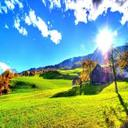

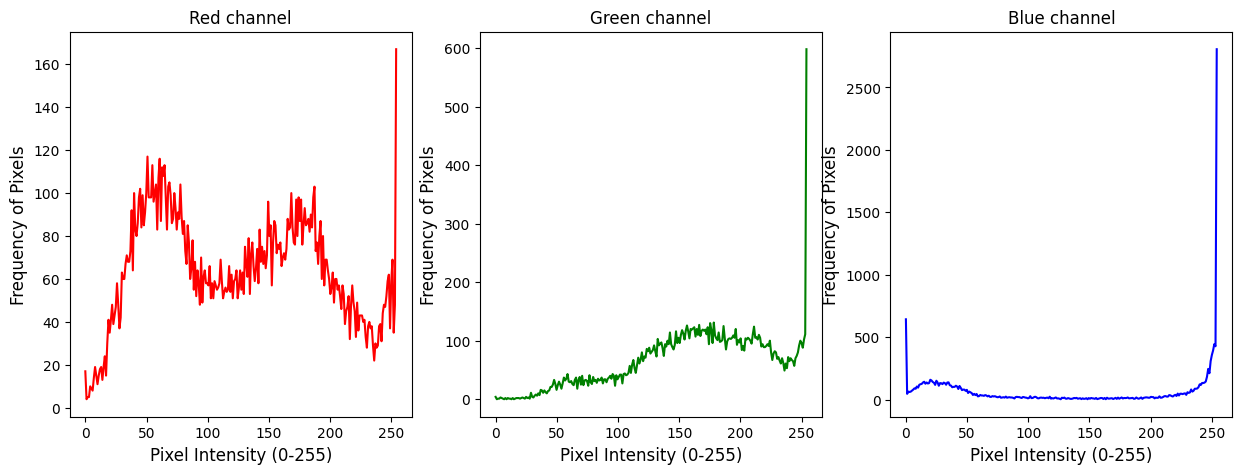

Correlation matrix between channels (Red, Green, Blue):
[[ 1.          0.71490927 -0.22536238]
 [ 0.71490927  1.          0.29695648]
 [-0.22536238  0.29695648  1.        ]]
Displaying Rain weather.


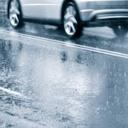

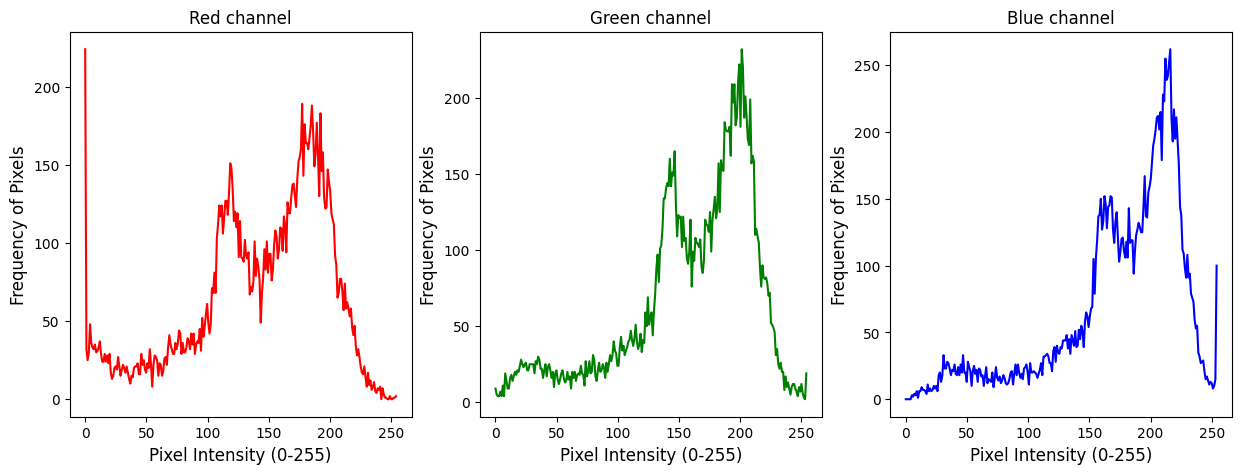

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.99502223 0.98724497]
 [0.99502223 1.         0.99699868]
 [0.98724497 0.99699868 1.        ]]
Displaying Cloudy weather.


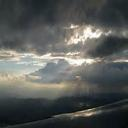

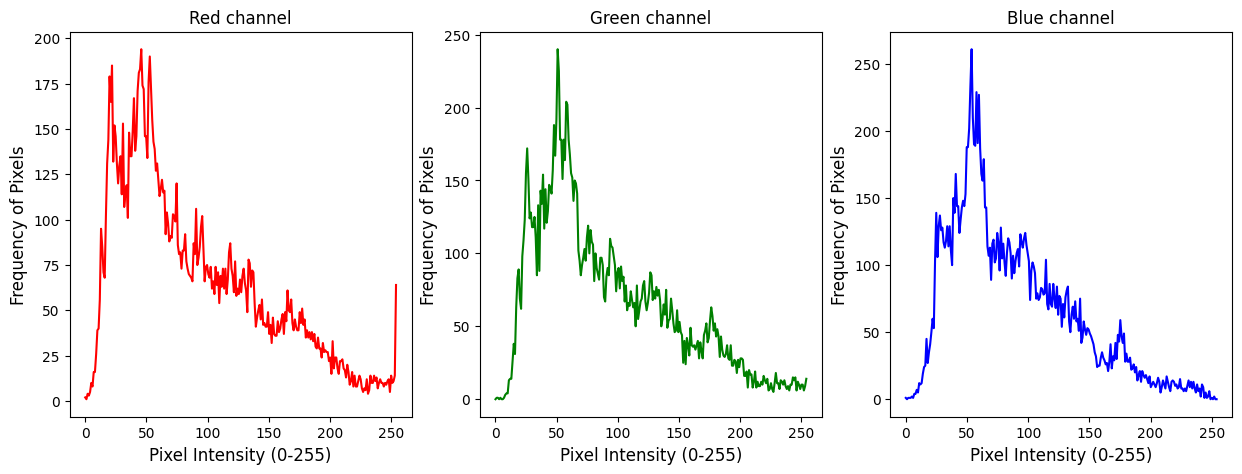

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.99655315 0.98574761]
 [0.99655315 1.         0.99427611]
 [0.98574761 0.99427611 1.        ]]
Displaying Sunrise weather.


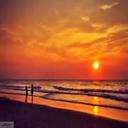

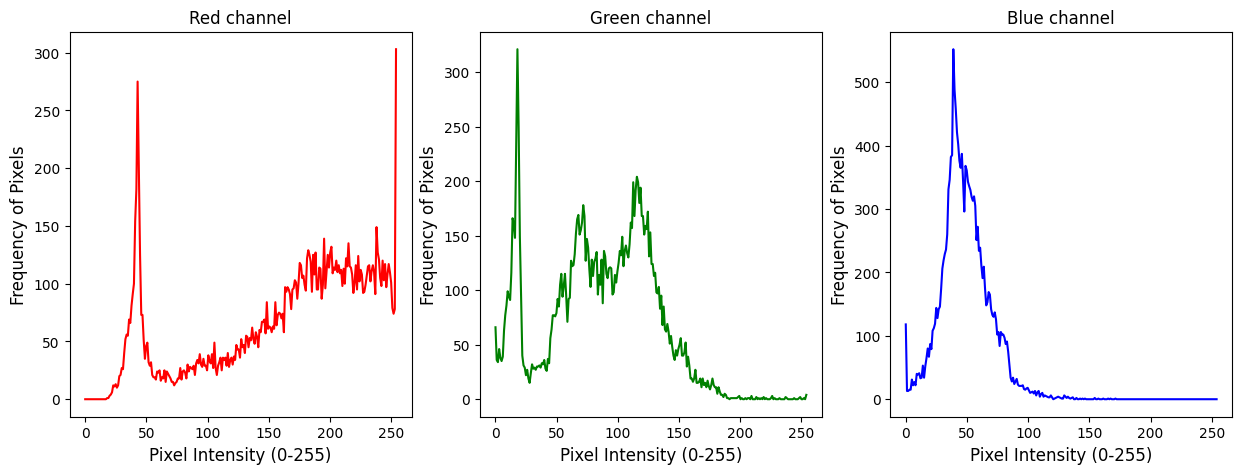

Correlation matrix between channels (Red, Green, Blue):
[[1.         0.87439753 0.11723518]
 [0.87439753 1.         0.35094855]
 [0.11723518 0.35094855 1.        ]]


In [11]:
for unique_label in set(df_scaled.label):
    image_path = df_scaled.loc[df_scaled.label == unique_label, 'file_path'].sample(1, random_state=24).values[0]
    processed_image = Image.open(image_path)
    print(f'Displaying {unique_label} weather.')
    display(processed_image)
    compute_and_plot_histograms(processed_image)
    correlation_matrix = calculate_channel_correlation(processed_image)
    print("Correlation matrix between channels (Red, Green, Blue):")
    print(correlation_matrix)


In [12]:
def find_images(class_name: str, names: tuple) -> Image:
    return [Image.open(os.path.join(PROCESSED_DATA_DIR, class_name, name)) for name in names]

showcase_images = {
    'Cloudy': find_images('Cloudy', ('cloudy1.jpg', 'cloudy100.jpg', 'cloudy286.jpg', 'cloudy265.jpg')),
    'Rain': find_images('Rain', ('rain7.jpg', 'rain118.jpg', 'rain137.jpg', 'rain202.jpg')),
    'Shine': find_images('Shine',  ('shine4.jpg', 'shine9.jpg', 'shine87.jpg', 'shine129.jpg')),
    'Sunrise': find_images('Sunrise', ('sunrise3.jpg', 'sunrise32.jpg', 'sunrise90.jpg', 'sunrise270.jpg'))
}
categories_num, images_num = len(showcase_images), len(showcase_images['Cloudy'])

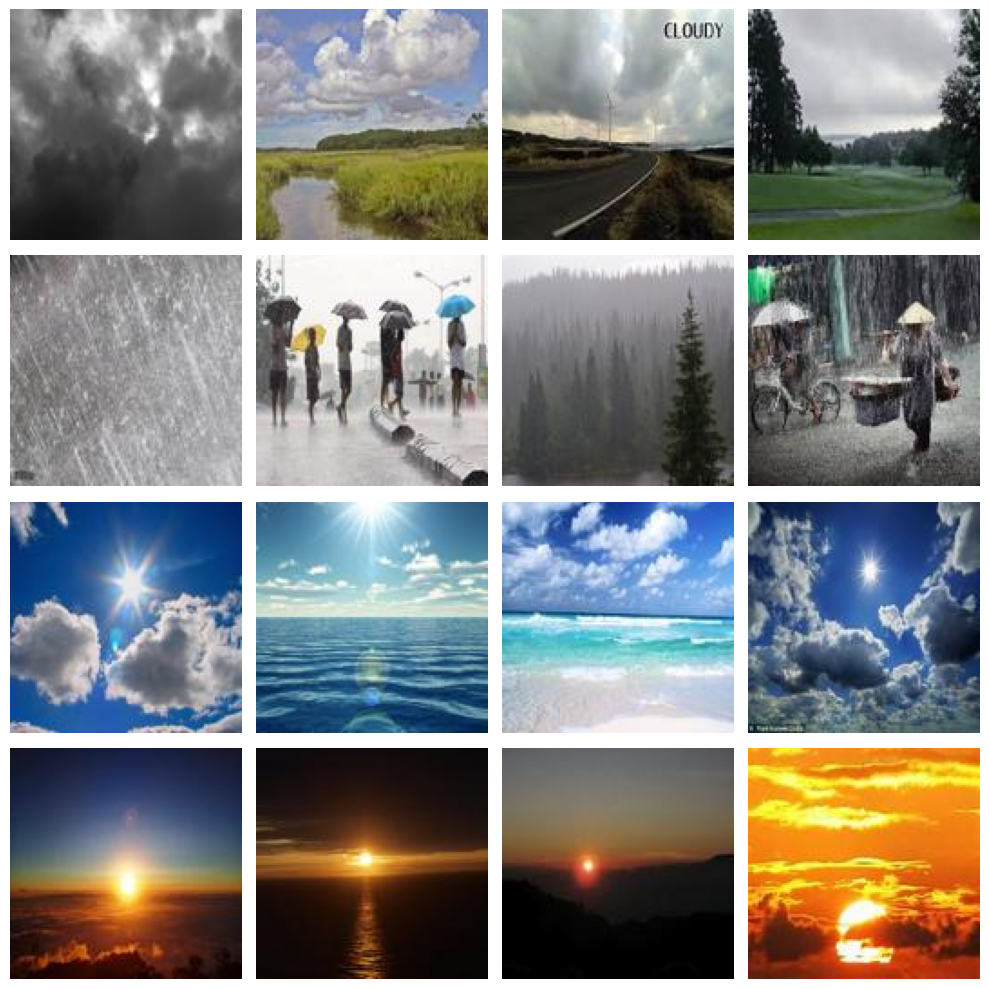

In [13]:
fig, axes = plt.subplots(categories_num, images_num, figsize=(10, 10)) 

images = []
labels = []

for label, images_inner in showcase_images.items():
    labels.append(label)
    images.extend(images_inner)

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off') 


plt.tight_layout()
plt.show()

## Visual images EDA

### Cloudy
On cloudy pictures we can see that the clouds are very different. Varying from relatively small to those that cover whole skies.
Also, weather and sunshine are different on all pictures, as well as back/foreground objects.

### Rain
On some pictures we can clearly see rain drops, on others - because of the camera, they look like noise "lines".
Also, there are images that don't even have rain drops on them, just people with umbrellas.

### Shine
There are a lot of clouds on Shine pictures. Also, sometimes the sun is not on the picture, which brings some noise.

### Sunrise
As you can see, there are also a lot of clouds on these pictures, however they seem to be the easiest for model to classify because of the colour schema.

## In general
We can see that the dataset is very noisy and this is a tough task for a model.

### Data augmentation:
In the raw data such deformations are already present (and so would be used for augmentation):
* Artistict brightness, contrast changes, etc
* Rotations

Next affine transformations would also be applied:
* Zoom
* Shift
* Flips

In [14]:
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.8, 1),
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_df, test_df = train_test_split(df_scaled, test_size=0.4, random_state=SEED, stratify=df_scaled['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED, stratify=train_df['label'])

train_batches = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

validation_batches = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

test_batches = val_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=os.getcwd(),
    x_col='file_path',
    y_col='label',
    target_size=RESIZED_IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

Found 538 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 449 validated image filenames belonging to 4 classes.


### Building the base model:
The first iteration is relatively shallow CNN with no particular tuning and regularizations applied

In [15]:
(WIDTH, HEIGHT), DIM = RESIZED_IMAGE_SIZE, 3
NUM_CLASSES = 4
NUM_FEATURES = 128
EPOCHS = 100

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [16]:
simple_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_FEATURES),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

d:\conda\envs\comp_int\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    with_p = "p_numerator" in history.history.keys()
    metrics_count = 3 if with_p else 2
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, metrics_count, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.subplot(1, metrics_count, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.show()

def model_stats(model, test_batches) -> None:
    images, labels = None, None
    test_batches.reset()

    for _ in range(len(test_batches)):
        x, y = next(test_batches)

        images = np.concatenate((images, x), axis=0) if images is not None else x
        labels = np.concatenate((labels, y), axis=0) if labels is not None else y

    y_true = np.argmax(labels, axis=1)
    y_pred_probs = model.predict(images, steps=test_batches.samples // BATCH_SIZE + 1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=test_batches.class_indices)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_batches.class_indices.keys()))

d:\conda\envs\comp_int\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 335ms/step - accuracy: 0.3798 - loss: 1.3135 - precision: 0.4843 - recall: 0.0291 - val_accuracy: 0.5259 - val_loss: 0.9042 - val_precision: 0.7470 - val_recall: 0.4593
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.6408 - loss: 0.7640 - precision: 0.8292 - recall: 0.4931 - val_accuracy: 0.7259 - val_loss: 0.7437 - val_precision: 0.7717 - val_recall: 0.5259
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - accuracy: 0.7195 - loss: 0.7062 - precision: 0.7859 - recall: 0.5194 - val_accuracy: 0.6074 - val_loss: 0.7828 - val_precision: 0.6857 - val_recall: 0.5333
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.6610 - loss: 0.7213 - precision: 0.7810 - recall: 0.5236 - val_accuracy: 0.7111 - val_loss: 0.6906 - val_precision: 0.8229 - val_recall: 0.5852
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.7632 - loss: 0.6520 - precision: 0.8281 - recall: 0.5016 - val_accuracy: 0.6815 - val_los

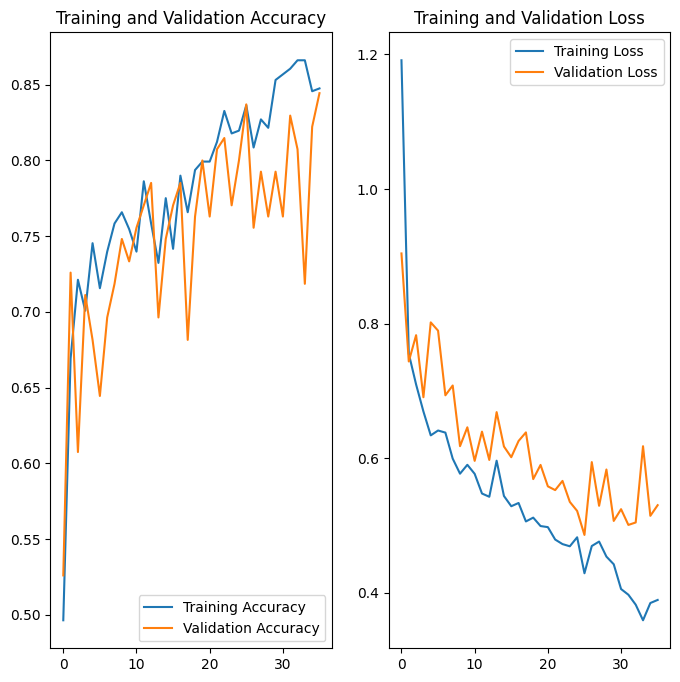

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8360 - loss: 0.4151 - precision: 0.8761 - recall: 0.8139
Test set results: [0.39954790472984314, 0.8440979719161987, 0.8785714507102966, 0.8218262791633606]


In [18]:
simple_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = simple_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = simple_cnn.evaluate(test_batches)
print("Test set results:", results)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


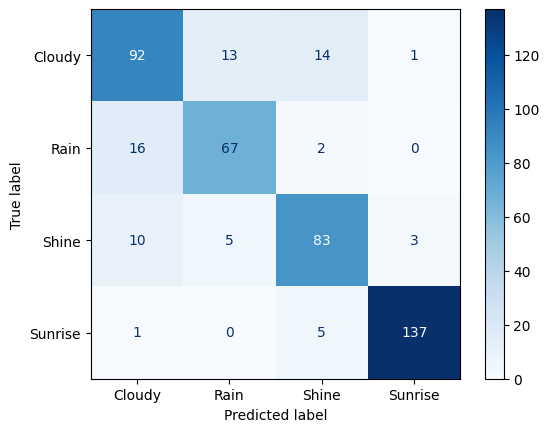

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.77      0.77      0.77       120
        Rain       0.79      0.79      0.79        85
       Shine       0.80      0.82      0.81       101
     Sunrise       0.97      0.96      0.96       143

    accuracy                           0.84       449
   macro avg       0.83      0.83      0.83       449
weighted avg       0.84      0.84      0.84       449



In [19]:
model_stats(simple_cnn, test_batches)

That's a pretty good result, considering how noisy data is. However, there is an issue - model stopped training as it was unable to find better classification rule meaning that it underfits the data. 

To fix underfit either better data or more complex model is needed. As we already processed our dataset we can introduce higher complexity by removing the aggregation step (`GlobalAveragePooling`), now the model will process whole output of our convolutional feature extractors.

As the state space grows bigger for this model, early stopping constraint would be softened.

In [20]:
better_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(NUM_FEATURES),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

d:\conda\envs\comp_int\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.3974 - loss: 3.5217 - precision: 0.7746 - recall: 0.6349 - val_accuracy: 0.6222 - val_loss: 0.8917 - val_precision: 0.7195 - val_recall: 0.4370
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.6494 - loss: 0.7740 - precision: 0.7405 - recall: 0.4812 - val_accuracy: 0.7481 - val_loss: 0.5964 - val_precision: 0.8288 - val_recall: 0.6815
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - accuracy: 0.8063 - loss: 0.5817 - precision: 0.8467 - recall: 0.7066 - val_accuracy: 0.8000 - val_loss: 0.5825 - val_precision: 0.8295 - val_recall: 0.7926
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - accuracy: 0.7810 - loss: 0.5286 - precision: 0.8134 - recall: 0.7725 - val_accuracy: 0.8519 - val_loss: 0.5051 - val_precision: 0.8898 - val_recall: 0.7778
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.8060 - loss: 0.5303 - precision: 0.8500 - recall: 0.7608 - val_accuracy: 0.8074 - val_los

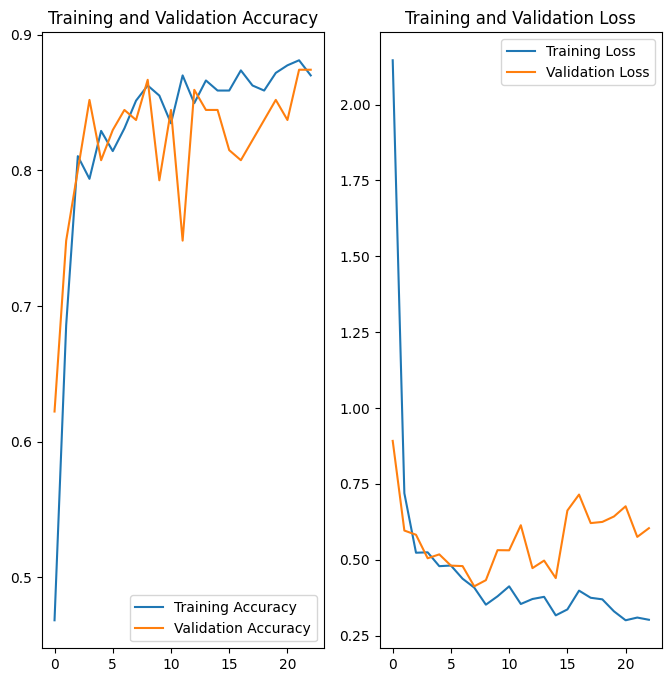

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8956 - loss: 0.3095 - precision: 0.9050 - recall: 0.8859
Test set results: [0.3552282452583313, 0.8641425371170044, 0.8784403800964355, 0.8530066609382629]


In [21]:
better_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
]

history = better_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = better_cnn.evaluate(test_batches)
print("Test set results:", results)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


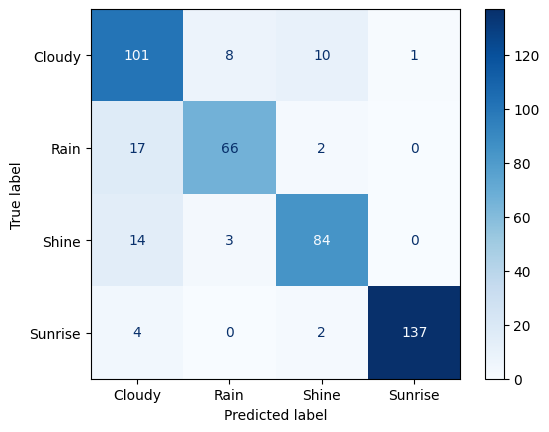

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.74      0.84      0.79       120
        Rain       0.86      0.78      0.81        85
       Shine       0.86      0.83      0.84       101
     Sunrise       0.99      0.96      0.98       143

    accuracy                           0.86       449
   macro avg       0.86      0.85      0.86       449
weighted avg       0.87      0.86      0.87       449



In [22]:
model_stats(better_cnn, test_batches)

This model is better, but now we face the overfit (validation trend does not match train trend), we find a good policy, but it does not generalize.

There are different solutions to this problem:
* Dropout - simply drop some of the values to further augment the inputs, but in a purely stochastic fashion
* Add class weights or regularize - our classes are not balanced, thus the distribution is flawed, which can be fixed by either explicitly stating some cases as more important or use regularization to find the best weight distribution. Here L2 Regulariztion would be used (as L1 regularization better works for implicit feature selection) 

In [23]:
best_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, DIM)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.1),
    layers.Dense(NUM_FEATURES, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(NUM_CLASSES, name="output", activation='softmax')
])

d:\conda\envs\comp_int\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.4548 - loss: 3.7762 - precision: 0.7829 - recall: 0.6547 - val_accuracy: 0.6815 - val_loss: 1.5784 - val_precision: 0.7636 - val_recall: 0.6222
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.7450 - loss: 1.3794 - precision: 0.8018 - recall: 0.6666 - val_accuracy: 0.7926 - val_loss: 1.0452 - val_precision: 0.8033 - val_recall: 0.7259
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.7996 - loss: 0.8848 - precision: 0.8595 - recall: 0.6971 - val_accuracy: 0.7481 - val_loss: 0.7980 - val_precision: 0.7795 - val_recall: 0.7333
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.7767 - loss: 0.7974 - precision: 0.8096 - recall: 0.7248 - val_accuracy: 0.7407 - val_loss: 0.7732 - val_precision: 0.7559 - val_recall: 0.7111
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.7860 - loss: 0.6298 - precision: 0.8192 - recall: 0.7444 - val_accuracy: 0.7778 - val_los

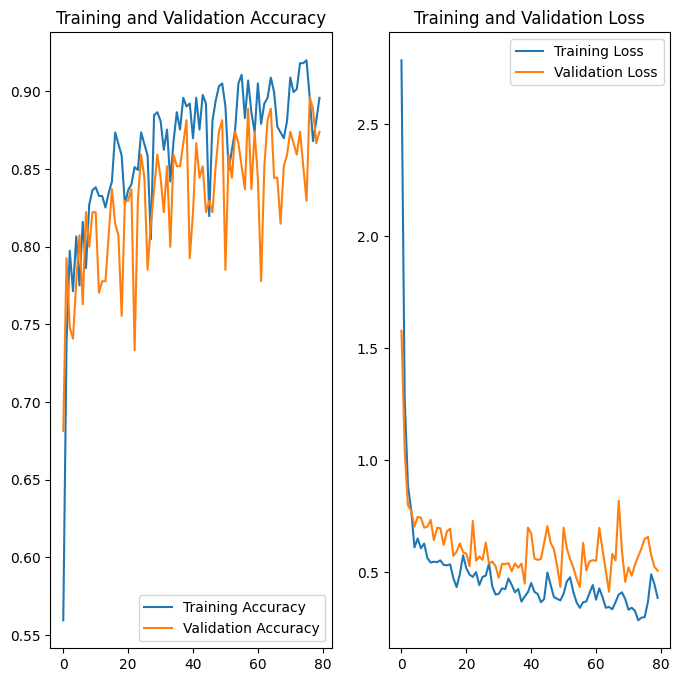

Evaluation:
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9004 - loss: 0.4058 - precision: 0.9230 - recall: 0.8914
Test set results: [0.3926270604133606, 0.890868604183197, 0.9168591499328613, 0.8841871023178101]


In [24]:
best_cnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=METRICS
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
]

history = best_cnn.fit(
    train_batches,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=validation_batches,
)

plot_history(history)

print(f"Evaluation:")
results = best_cnn.evaluate(test_batches)
print("Test set results:", results)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


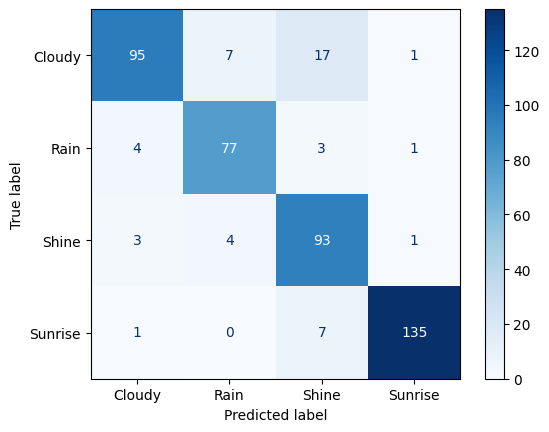

Classification Report:
              precision    recall  f1-score   support

      Cloudy       0.92      0.79      0.85       120
        Rain       0.88      0.91      0.89        85
       Shine       0.78      0.92      0.84       101
     Sunrise       0.98      0.94      0.96       143

    accuracy                           0.89       449
   macro avg       0.89      0.89      0.89       449
weighted avg       0.90      0.89      0.89       449



In [25]:
model_stats(best_cnn, test_batches)

Here overfit still happens, but it is postponed allowing us to reach better performance.